# Hypotheses

## income - household_size
Линейная зависимость: чем меньше домохозяйство, тем больше среднедушевой доход

y = a1 * household_size + ...

Предполагаем, что a1 < 0

## income - distance
Income city donuts: В центре и на окраине живут богатые, а между ними находится прослойка из более бедного населения на кольце с радиусом около 20 км

y = a1 * ((distance - 20) ^ 2) + ...

Предполагаем, что a1 > 0

## income - (density and favelas and distance)
В самых плотных районах - густонаселённых фавелах и в ненаселённых сельских территориях доход меньше, а в плотном центре - выше

y = a1 * lot_favelas * density + a2 * moderate_favelas * density + a3 * distance / density

Предполагаем, что a1, a2, a3 < 0

# Data preparation

In [155]:
# magic to work independently
# add your json file from kaggle with username and key

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"egorbogautdinov","key":"78b2c9e37717e5f65c50ab9160b15cbd"}'}

In [156]:
# kaggle 
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuspicanco/sao-paulo-geospatial-features
!ls

sao-paulo-geospatial-features.zip: Skipping, found more recently modified local copy (use --force to force download)
 density.png		    income_distance.png
 distance.png		    income_household_size.png
 distributions_target.png   income.png
 distributions_x.png	   'kaggle (1).json'
 drive			   'kaggle (2).json'
 favelas.png		    kaggle.json
 files			    parks.png
 household_size.png	    sample_data
 income_density.png	    sao-paulo-geospatial-features.zip


In [157]:
# installing for newbies
!pip install pyarrow geopandas shapely fiona pandas numpy matplotlib seaborn 
!pip install pandas_profiling --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
# importing modules
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import zipfile

In [159]:
# unzipping
zip_ref = zipfile.ZipFile('sao-paulo-geospatial-features.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [160]:
# reading file
df = gpd.read_parquet(
    '/content/files/tb_neighborhood.parquet'
    )

# verifying the results:
print(df.shape)
print(df.crs)

# dealing with missing data
df = df.fillna(0)

# setting correct crs
df.set_crs('epsg:32723', inplace=True)
df.head()

(1231, 115)
None


,neighborhood_name,neighborhood_alphabetized_population,neighborhood_area_in_hectares,neighborhood_average_age_household_leaders,neighborhood_average_age_women_household_leaders,neighborhood_average_household_income,neighborhood_average_income_household_leaders,neighborhood_average_income_women_household_leaders,neighborhood_average_ipvs_factor_1,neighborhood_average_ipvs_factor_1_rural,...,neighborhood_average_number_fronts_corners,neighborhood_average_obsolescence_factor,neighborhood_average_owner_start_contribution_year,neighborhood_average_property_age,neighborhood_average_years_of_ownership,neighborhood_n_parks,neighborhood_total_park_area,neighborhood_n_favelas,neighborhood_total_favela_area,neighborhood_n_train_stations
0,Jardim Coimbra,4811.0,45.887031,49.651356,51.714133,2342.758244,1254.612967,874.041900,-0.058200,0.0,...,0.121133,0.496722,1975.037292,83.542382,41.962708,0,0.0,1,8837.0,0
1,Jardim Fonte do Morumbi,1975.0,25.236298,47.097162,46.484912,17227.457275,11882.720812,4814.536012,1.657150,0.0,...,1.104917,0.531884,1998.345412,872.349726,18.654588,0,0.0,0,0.0,0
2,Jardim Jussara,1018.0,13.479666,48.800433,49.767733,4748.411633,2851.482167,2219.680700,1.293600,0.0,...,0.418890,0.649997,1977.535257,91.249500,39.464743,0,0.0,0,0.0,0
3,Jardim Santa Fe,4506.0,839.903989,35.254900,35.352608,1689.054242,873.422850,614.868808,0.044375,0.0,...,0.220175,0.552342,1988.615581,469.722987,28.384419,0,0.0,1,1024.0,0
4,Vila Doutor Eiras,774.0,12.345645,48.360650,46.578050,3024.896400,1296.206200,1053.096000,0.656150,0.0,...,0.194921,0.599121,1970.629469,77.491689,46.370531,0,0.0,0,0.0,0


In [161]:
# center of the city
from shapely.geometry import Point
d = {'name': ['center'] * 1251, 'geometry': [Point(-46.636979, -23.544251)] * 1251}
center_geom = gpd.GeoDataFrame(d, crs="EPSG:4326")
center_geom.set_crs("EPSG:32723", inplace=True, allow_override=True)
distance = df.centroid.distance(center_geom)

# adding distance to center variable
df.set_crs('epsg:32723', inplace=True, allow_override=True)
df['centroid'] = df.centroid
df['distance'] = df.centroid.distance(center_geom) * 108 # to make km

/usr/local/lib/python3.8/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/usr/local/lib/python3.8/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [162]:
# dropping unnecessary columns
import random
random.seed(42)
# targets: average per capita income
# quantitative: distance to center, density, avg household residents
# qualitative: is there a park (0 - no, 1 - yes), are there favellas (0 - no, 1 - few (1-2), 2 lot(3+)))

# df_neighborhood = gpd.GeoDataFrame()
df_neighborhood = df[list(df.columns[[14, 1, 2, 52, 33, 110, 112, -1, 92]])]

# park
df_neighborhood['parks'] = df_neighborhood['neighborhood_n_parks'].apply(lambda x: random.choices([0,1], weights=[0.8, 0.2], k=100)[0] if x == 0 else 1)
df_neighborhood['parks_qual'] = df_neighborhood['parks'].apply(lambda x: 'no_parks' if x == 0 else 'having_parks')


# favellas
df_neighborhood['favelas'] = df_neighborhood['neighborhood_n_favelas'].apply(lambda x: 0 if x == 0 else (1 if x == 1 or x == 2 else 2))
df_neighborhood['favelas_qual'] = df_neighborhood['neighborhood_n_favelas'].apply(lambda x: 'no_favelas' if x == 0 else ('moderate_favelas' if x == 1 or x == 2 else 'lot_favelas'))

df_neighborhood = df_neighborhood[df_neighborhood.columns[[0,3,4,7,8,9,10,11, 12]]]
df_neighborhood = df_neighborhood.rename(columns={'neighborhood_average_per_capita_income':'income', 'neighborhood_average_residents_per_household':'household_size', 'neighborhood_average_population_density':'density'})
df_neighborhood.head()

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,income,household_size,density,distance,geometry,parks,parks_qual,favelas,favelas_qual
0,738.660489,3.196667,131.855138,17.346975,"POLYGON ((-46.474 -23.536, -46.475 -23.535, -4...",0,no_parks,1,moderate_favelas
1,5106.237587,3.385000,137.102159,12.759830,"POLYGON ((-46.724 -23.630, -46.724 -23.629, -4...",0,no_parks,0,no_favelas
2,1789.056900,2.666667,1664.658234,13.419143,"POLYGON ((-46.742 -23.600, -46.744 -23.602, -4...",1,having_parks,0,no_favelas
3,501.996875,3.414167,45.851066,21.844598,"POLYGON ((-46.814 -23.400, -46.813 -23.399, -4...",1,having_parks,1,moderate_favelas
4,944.416000,3.205000,68.201860,22.214359,"POLYGON ((-46.437 -23.495, -46.436 -23.495, -4...",0,no_parks,0,no_favelas


In [163]:
df_quant = df_neighborhood.drop(['parks_qual', 'favelas_qual'], axis=1)
df_quant.head()

,income,household_size,density,distance,geometry,parks,favelas
0,738.660489,3.196667,131.855138,17.346975,"POLYGON ((-46.474 -23.536, -46.475 -23.535, -4...",0,1
1,5106.237587,3.385000,137.102159,12.759830,"POLYGON ((-46.724 -23.630, -46.724 -23.629, -4...",0,0
2,1789.056900,2.666667,1664.658234,13.419143,"POLYGON ((-46.742 -23.600, -46.744 -23.602, -4...",1,0
3,501.996875,3.414167,45.851066,21.844598,"POLYGON ((-46.814 -23.400, -46.813 -23.399, -4...",1,1
4,944.416000,3.205000,68.201860,22.214359,"POLYGON ((-46.437 -23.495, -46.436 -23.495, -4...",0,0


#Maps

In [164]:
# defining colormap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = ["blue", "lightblue", "white", 'pink', 'red']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

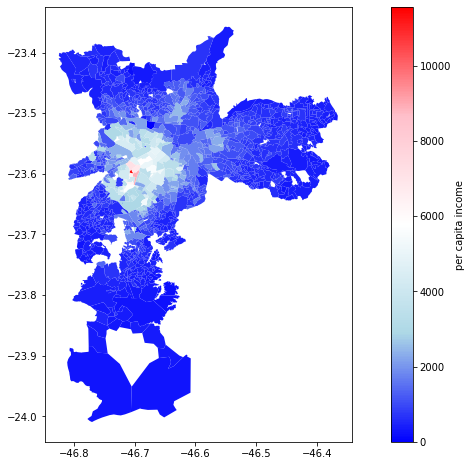

In [165]:
# static map

df_neighborhood.plot(
    column = 'income',
    legend = True,
    legend_kwds={
        'label': "per capita income",
        'orientation': "vertical"
    },
    figsize = (14, 8),
    cmap = cmap1
)
plt.savefig("income.png", dpi=400)
files.download('income.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

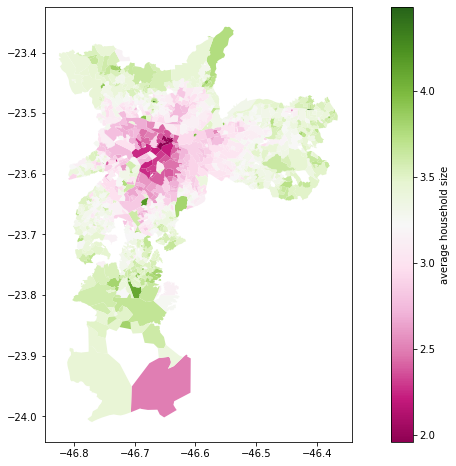

In [166]:
# static map

df_neighborhood.plot(
    column = 'household_size',
    legend = True,
    legend_kwds={
        'label': "average household size",
        'orientation': "vertical"
    },
    figsize = (14, 8),
    cmap = 'PiYG'
)
plt.savefig("household_size.png", dpi=400)
files.download('household_size.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

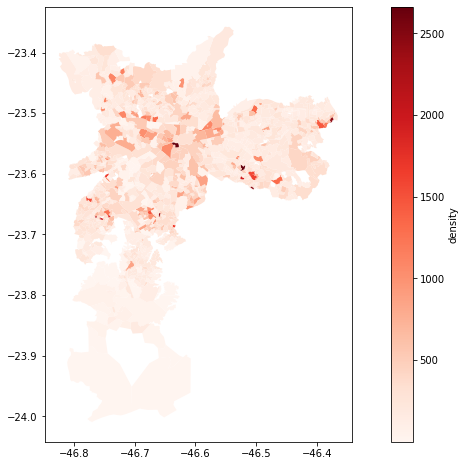

In [167]:
# static map

df_neighborhood.plot(
    column = 'density',
    legend = True,
    legend_kwds={
        'label': "density",
        'orientation': "vertical"
    },
    figsize = (14, 8),
    cmap = 'Reds'
)
plt.savefig("density.png", dpi=400)
files.download('density.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

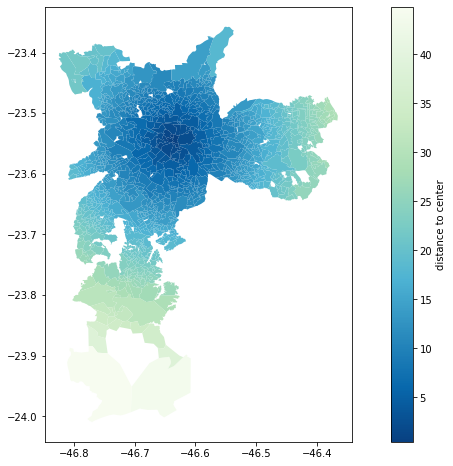

In [168]:
# static map

df_neighborhood.plot(
    column = 'distance',
    legend = True,
    legend_kwds={
        'label': "distance to center",
        'orientation': "vertical"
    },
    figsize = (14, 8),
    cmap = 'GnBu_r'
)
plt.savefig("distance.png", dpi=400)
files.download('distance.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

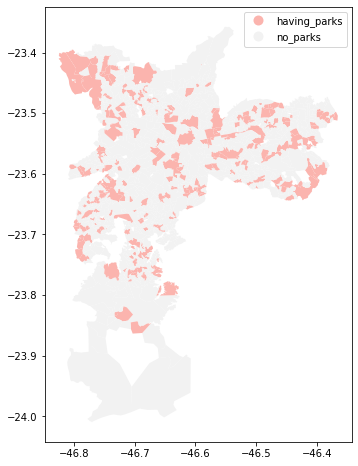

In [169]:
# static map

df_neighborhood.plot(
    column = 'parks_qual',
    legend = True,
    figsize = (14, 8),
    cmap = 'Pastel1'
)
plt.savefig("parks.png", dpi=400)
files.download('parks.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

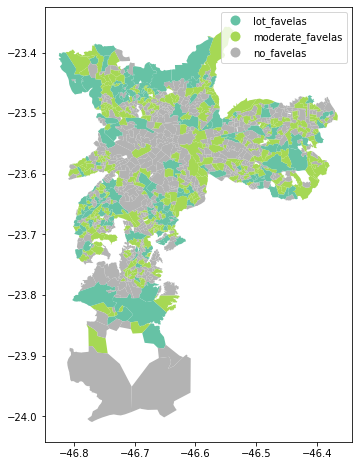

In [170]:
# static map

df_neighborhood.plot(
    column = 'favelas_qual',
    legend = True,
    figsize = (14, 8),
    cmap='Set2'
)
plt.savefig("favelas.png", dpi=400)
files.download('favelas.png')
plt.show()

# EDA


In [171]:
df_quant = df_quant.drop('geometry', axis=1)
import pandas_profiling as pp
eda = pp.ProfileReport(df_quant)
display(eda)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Target variable

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

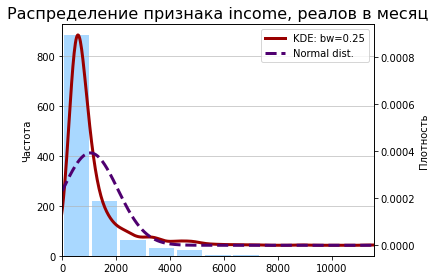

In [172]:
from scipy import stats
import math

fig, ax1 = plt.subplots()
x = df_quant['income']
ax1.hist(x=x, bins=int(1+3.322*math.log10(len(x))), color='#42aaff',
                        alpha=0.45, rwidth=0.9)
ax1.grid(axis='y', alpha=0.75)
# ax1.set_xlabel('Распределение признака %s' %(column[1] + ', ' + sizes[column[0]]))#, font='Sans', fontsize=14)
ax1.set_ylabel('Частота')
ax1.set_title('Распределение признака income, реалов в месяц', fontsize=16)

bw = 0.25
ax2 = ax1.twinx()
# ax2 = x.plot.kde(bw_method='silverman', label='KDE: silverman', color='#ffd800')
ax2 = x.plot.kde(bw_method=bw, label='KDE: bw=%s' %bw, color='#990000', linewidth=3)
ax2.set_ylabel('Плотность')
ax2.tick_params(axis='y')

x_min = min(x)
x_max = max(x)
mean = np.mean(x)
std = np.std(x)
x_norm = np.linspace(x_min, x_max, 1231)
y_norm = stats.norm.pdf(x_norm,mean,std)
ax2.plot(x_norm,y_norm, color='#4f0070', linestyle='dashed', label='Normal dist.', linewidth=3)
# ax2.vlines(x.median(), plt.ylim()[0], plt.ylim()[1], colors='#F8173E', linewidth=1.5, label='Медиана распределения')

plt.legend()
plt.xlim(min(x), max(x))
plt.savefig("distributions_target.png", dpi=400)
files.download("distributions_target.png")
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

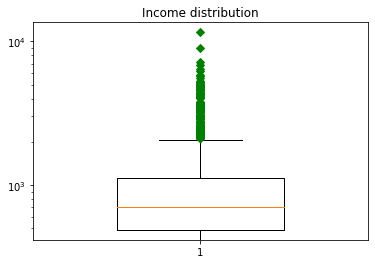

In [205]:
D = df_quant['income']
# plot
fig, ax = plt.subplots()
VP = ax.boxplot(D, 0, 'gD', widths=0.5)
ax.set_title('Income distribution')
plt.yscale('log') 
plt.savefig("target_boxplot.png", dpi=400)
files.download("target_boxplot.png")
plt.show()

# Quantitative dependent variables

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

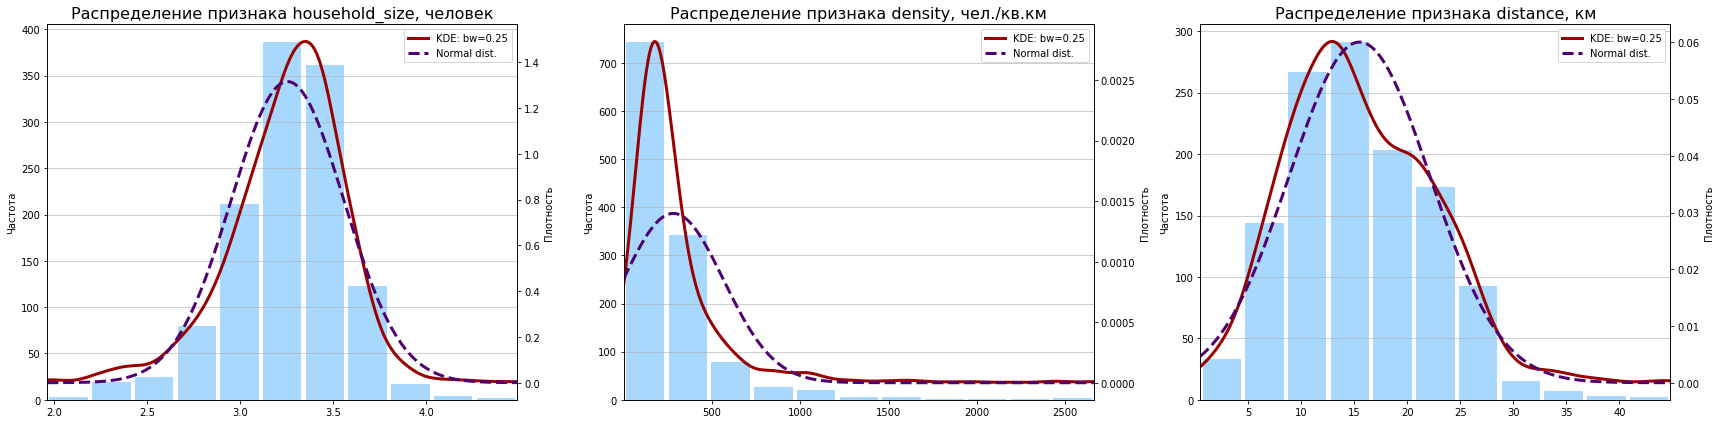

In [174]:
# building hists

sizes = ['реалов в месяц', 'человек', 'чел./кв.км', 'км']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
for column in enumerate(df_quant.columns[1:4]):
    ax1 = axes[column[0] % 3]
    x = df_quant[column[1]]
    ax1.hist(x=x, bins=int(1+3.322*math.log10(len(x))), color='#42aaff',
                            alpha=0.45, rwidth=0.9)
    ax1.grid(axis='y', alpha=0.75)
    # ax1.set_xlabel('Распределение признака %s' %(column[1] + ', ' + sizes[column[0]]))#, font='Sans', fontsize=14)
    ax1.set_ylabel('Частота')
    ax1.set_title('Распределение признака %s' %(column[1] + ', ' + sizes[column[0] + 1]), fontsize=16)

    bw = 0.25
    ax2 = ax1.twinx()
    # ax2 = x.plot.kde(bw_method='silverman', label='KDE: silverman', color='#ffd800')
    ax2 = x.plot.kde(bw_method=bw, label='KDE: bw=%s' %bw, color='#990000', linewidth=3)
    ax2.set_ylabel('Плотность')
    ax2.tick_params(axis='y')

    x_min = min(x)
    x_max = max(x)
    mean = np.mean(x)
    std = np.std(x)
    x_norm = np.linspace(x_min, x_max, 1231)
    y_norm = stats.norm.pdf(x_norm,mean,std)
    ax2.plot(x_norm,y_norm, color='#4f0070', linestyle='dashed', label='Normal dist.', linewidth=3)
    # ax2.vlines(x.median(), plt.ylim()[0], plt.ylim()[1], colors='#F8173E', linewidth=1.5, label='Медиана распределения')

    plt.legend()
    plt.xlim(min(x), max(x))
plt.savefig("distributions_x.png", dpi=600)
files.download("distributions_x.png")
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

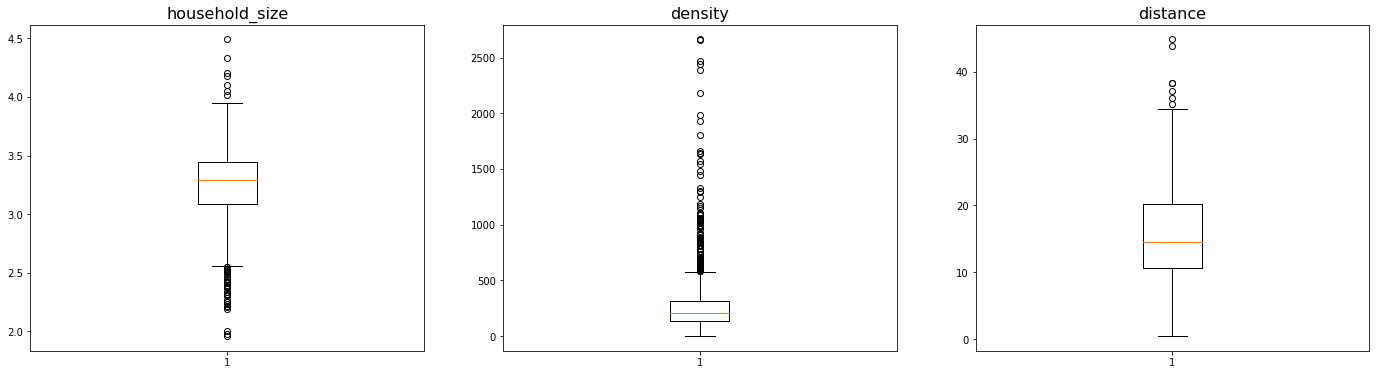

In [206]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
for column in enumerate(df_quant.columns[1:4]):
    ax1 = axes[column[0] % 3]
    D = df_quant[column[1]]
    ax1.boxplot(D, 0)
    ax1.set_title(column[1], fontsize=16)
plt.savefig("boxplots_var.png", dpi=400)
files.download("boxplots_var.png")
plt.show()

In [176]:
stat = df_quant.describe()
stat.loc['var'] = df_quant.var().tolist()
stat.loc['skew'] = df_quant.skew().tolist()
stat.loc['kurt'] = df_quant.kurtosis().tolist()
stat.loc['IQR'] = stat.loc['75%'] - stat.loc['25%']
stat.loc['median'] = df_quant.median().tolist()
stat

,income,household_size,density,distance,parks,favelas
count,1.231000e+03,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000
mean,1.048143e+03,3.253691,280.262190,15.487350,0.219334,0.528026
std,1.017880e+03,0.303351,285.294117,6.645421,0.413963,0.698886
min,0.000000e+00,1.960789,0.020776,0.475048,0.000000,0.000000
25%,4.878222e+02,3.090000,137.332468,10.607123,0.000000,0.000000
50%,6.999347e+02,3.288333,205.833269,14.603564,0.000000,0.000000
75%,1.122501e+03,3.447500,315.185690,20.283751,0.000000,1.000000
max,1.155996e+04,4.490000,2662.352968,44.826879,1.000000,2.000000
var,1.036080e+06,0.092022,81392.733295,44.161626,0.171366,0.488442
skew,3.460090e+00,-0.635712,3.869505,0.459072,1.358201,0.952024


# Qualitative dependent variables

In [177]:
df_qual = df_neighborhood[['income', 'parks_qual', 'favelas_qual']]
df_qual.head()

,income,parks_qual,favelas_qual
0,738.660489,no_parks,moderate_favelas
1,5106.237587,no_parks,no_favelas
2,1789.056900,having_parks,no_favelas
3,501.996875,having_parks,moderate_favelas
4,944.416000,no_parks,no_favelas


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

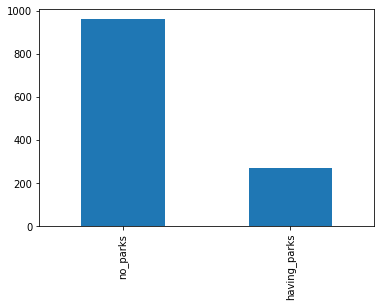

In [207]:
df_qual['parks_qual'].value_counts().plot(kind='bar')
plt.savefig("parks_bar.png", dpi=400)
files.download("parks_bar.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

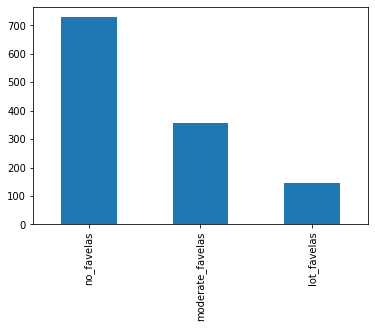

In [208]:
df_qual['favelas_qual'].value_counts().plot(kind='bar')
plt.savefig("fav_bar.png", dpi=400)
files.download("fav_bar.png")
plt.show()

# Correlations

In [180]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, color='tab:blue', color_map=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=0.5, c=color)
    if color_map is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in color_map.items()]
        ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc=1)
    ax.grid(True)
    
    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y))) / 5000
    lim = (int(xymax/binwidth) + 1) * binwidth
    ax_histx.hist(x)
    ax_histy.hist(y, orientation='horizontal')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

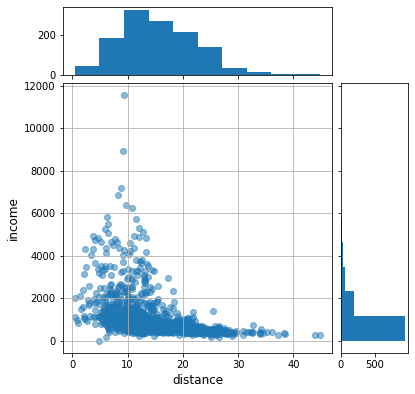

In [181]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

scatter_hist(df_quant['distance'], 
             df_quant['income'],
             ax, ax_histx, ax_histy
            )
ax.set_xlabel('distance', fontsize=12)
ax.set_ylabel('income', fontsize=12)
plt.savefig('income_distance.png', dpi=400)
files.download('income_distance.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

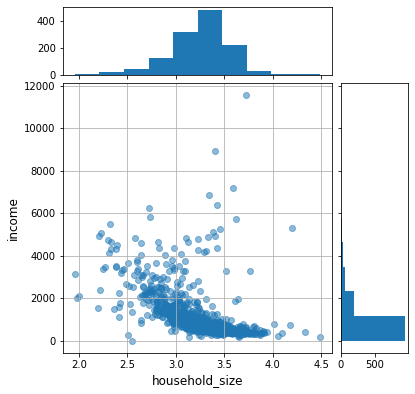

In [182]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

scatter_hist(df_quant['household_size'], 
             df_quant['income'],
             ax, ax_histx, ax_histy
            )
ax.set_xlabel('household_size', fontsize=12)
ax.set_ylabel('income', fontsize=12)
plt.savefig('income_household_size.png', dpi=400)
files.download('income_household_size.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

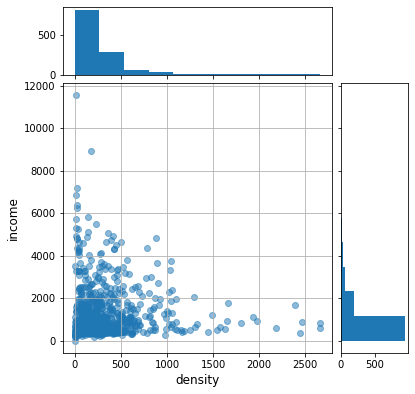

In [183]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

scatter_hist(df_quant['density'], 
             df_quant['income'],
             ax, ax_histx, ax_histy
            )
ax.set_xlabel('density', fontsize=12)
ax.set_ylabel('income', fontsize=12)
plt.savefig('income_density.png', dpi=400)
files.download('income_density.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

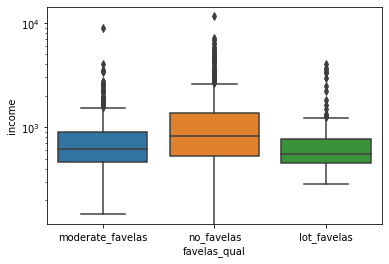

In [209]:
sns.boxplot(data=df_qual, x="favelas_qual", y="income")
plt.yscale('log') 
plt.savefig("fav_target_boxplot.png", dpi=400)
files.download("fav_target_boxplot.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

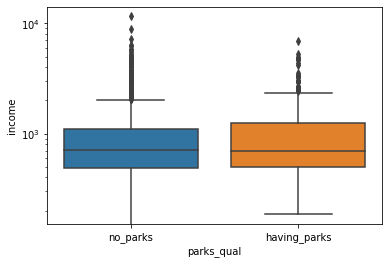

In [210]:
sns.boxplot(data=df_qual, x="parks_qual", y="income")
plt.yscale('log')
plt.savefig("park_target_boxplot.png", dpi=400)
files.download("park_target_boxplot.png") 
plt.show()

In [186]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,income,household_size,density,distance
income,1.000000,-0.528958,0.001588,-0.471549
household_size,-0.528958,1.000000,-0.121774,0.559306
density,0.001588,-0.121774,1.000000,-0.134794
distance,-0.471549,0.559306,-0.134794,1.000000


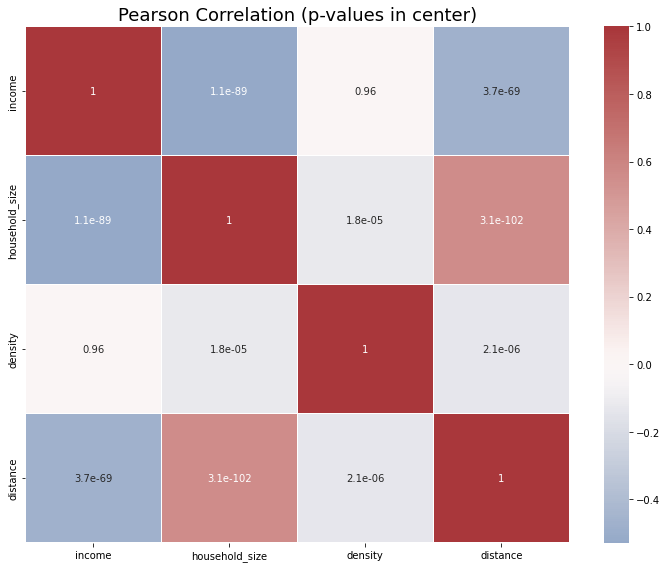

In [211]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

columns_names = {}
for i in range(len(df_quant.columns) - 2):
    columns_names[i] = df_quant.columns[i]

df_temp = df_quant[df_quant.columns[:4]]
df1 = pd.DataFrame(scaler.fit_transform(df_temp))
p_values = df1.corr(method=pearsonr_pval)
correlation_numbers = df1.corr(method='pearson')
correlation = correlation_numbers.rename(columns_names, axis='index').rename(columns_names, axis='columns')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlation, annot=p_values, cmap='vlag',center=0,linewidths=.2)
ax.set_title('Pearson Correlation (p-values in center)', fontsize=18)
plt.savefig("corr_pearson.png", dpi=400)
files.download("corr_pearson.png")
plt.tight_layout()
plt.show
correlation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,income,household_size,density,distance
income,1.000000,-0.791260,-0.078899,-0.701696
household_size,-0.791260,1.000000,-0.026858,0.596079
density,-0.078899,-0.026858,1.000000,-0.120628
distance,-0.701696,0.596079,-0.120628,1.000000


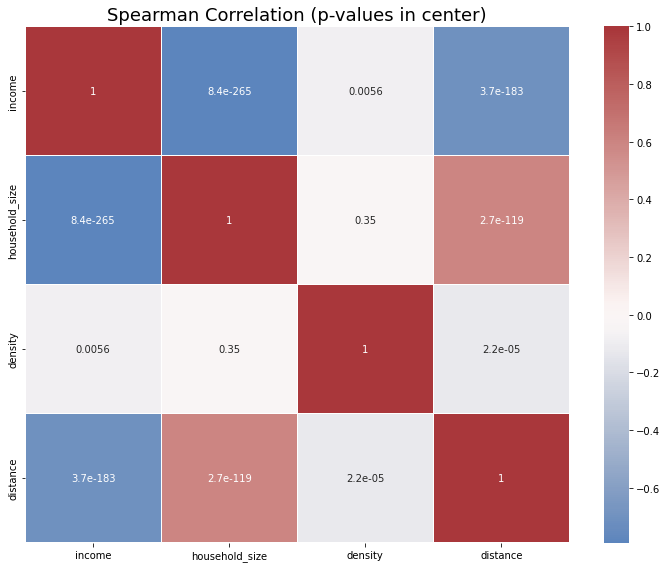

In [212]:
df_temp = df_quant[df_quant.columns[:4]]
df1 = pd.DataFrame(scaler.fit_transform(df_temp))
p_values = df1.corr(method=spearmanr_pval)
correlation_numbers = df1.corr(method='spearman')
correlation = correlation_numbers.rename(columns_names, axis='index').rename(columns_names, axis='columns')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlation, annot=p_values, cmap='vlag',center=0,linewidths=.2)
ax.set_title('Spearman Correlation (p-values in center)', fontsize=18)
plt.savefig("corr_spearman.png", dpi=400)
files.download("corr_spearman.png")
plt.tight_layout()
plt.show
correlation

In [189]:
crosstab = pd.crosstab(df_qual.parks_qual, df_qual.favelas_qual)
X2 = stats.chi2_contingency(crosstab.values, correction=False)[0]
n = np.sum(crosstab.values)
minDim = min(crosstab.values.shape)-1
V = np.sqrt((X2/n) / minDim)
print('Chi Squared: ', round(X2, 3))
print('Cramers V: ', round(V, 3))
crosstab

Chi Squared:  4.534
Cramers V:  0.061


favelas_qual,lot_favelas,moderate_favelas,no_favelas
parks_qual,,,
having_parks,42,78,150
no_parks,105,278,578


# Basic model

In [213]:
import statsmodels.api as sm

nd = df_neighborhood.copy()
nd_train = nd.sample(frac=0.8, random_state=42) 
nd_test = nd.loc[~nd.index.isin(nd_train.index)] 
mq = pd.DataFrame([], columns=['R^2', 'adjR^2', 'AIC'])

Y = nd_train['income']

In [214]:
# basic model 00
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'density', 'household_size']]], axis=1)
X = sm.add_constant(X)
linreg00 = sm.OLS(Y,X)
fitmod00 = linreg00.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod00.summary())

q = pd.DataFrame([fitmod00.rsquared, fitmod00.rsquared_adj, fitmod00.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

from statsmodels.stats.diagnostic import het_white
e = fitmod00.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     103.1
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.46e-100
Time:                        23:36:08   Log-Likelihood:                -7923.9
No. Observations:                 985   AIC:                         1.586e+04
Df Residuals:                     978   BIC:                         1.590e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,151.159667
1,parks_qual_having_parks,1.008368
2,favelas_qual_moderate_favelas,1.101764
3,favelas_qual_lot_favelas,1.110817
4,distance,1.477422
5,density,1.037618
6,household_size,1.528938


,0
LM,7.815569e+01
LM_P,6.298855e-08
F,3.601002e+00
F_P,2.831665e-08


In [215]:
# basic with no const 01
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'density', 'household_size']]], axis=1)
# X = sm.add_constant(X)
linreg01 = sm.OLS(Y,X)
fitmod01 = linreg01.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod01.summary())

q = pd.DataFrame([fitmod01.rsquared, fitmod01.rsquared_adj, fitmod01.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)


 **** Оценка базовой модели - полный состав ****
                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.586
Model:                            OLS   Adj. R-squared (uncentered):              0.583
Method:                 Least Squares   F-statistic:                              231.0
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                   1.37e-183
Time:                        23:36:08   Log-Likelihood:                         -8105.8
No. Observations:                 985   AIC:                                  1.622e+04
Df Residuals:                     979   BIC:                                  1.625e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>

,vars,VIF
0,parks_qual_having_parks,1.287768
1,favelas_qual_moderate_favelas,1.539975
2,favelas_qual_lot_favelas,1.238285
3,distance,8.323887
4,density,1.935113
5,household_size,10.832850


In [216]:
# no const no density 02
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'household_size']]], axis=1)
# X = sm.add_constant(X)
linreg02 = sm.OLS(Y,X)
fitmod02 = linreg02.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod02.summary())

q = pd.DataFrame([fitmod02.rsquared, fitmod02.rsquared_adj, fitmod02.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)


 **** Оценка базовой модели - полный состав ****
                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.586
Model:                            OLS   Adj. R-squared (uncentered):              0.584
Method:                 Least Squares   F-statistic:                              277.1
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                   1.06e-184
Time:                        23:36:08   Log-Likelihood:                         -8106.1
No. Observations:                 985   AIC:                                  1.622e+04
Df Residuals:                     980   BIC:                                  1.625e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>

,vars,VIF
0,parks_qual_having_parks,1.287742
1,favelas_qual_moderate_favelas,1.535080
2,favelas_qual_lot_favelas,1.226948
3,distance,8.119328
4,household_size,9.149021


In [217]:
# no density 03
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'household_size']]], axis=1)
X = sm.add_constant(X)
linreg03 = sm.OLS(Y,X)
fitmod03 = linreg03.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod03.summary())

q = pd.DataFrame([fitmod03.rsquared, fitmod03.rsquared_adj, fitmod03.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

from statsmodels.stats.diagnostic import het_white
e = fitmod03.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     121.8
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          3.06e-100
Time:                        23:36:08   Log-Likelihood:                -7927.2
No. Observations:                 985   AIC:                         1.587e+04
Df Residuals:                     979   BIC:                         1.590e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,147.013918
1,parks_qual_having_parks,1.008243
2,favelas_qual_moderate_favelas,1.095468
3,favelas_qual_lot_favelas,1.095825
4,distance,1.467460
5,household_size,1.522027


,0
LM,45.869747
LM_P,0.000102
F,2.954989
F_P,0.000082


In [218]:
# no const no household_size 04
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'density']]], axis=1)
# X = sm.add_constant(X)
linreg04 = sm.OLS(Y,X)
fitmod04 = linreg04.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod04.summary())

q = pd.DataFrame([fitmod04.rsquared, fitmod04.rsquared_adj, fitmod04.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)


 **** Оценка базовой модели - полный состав ****
                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.361
Model:                            OLS   Adj. R-squared (uncentered):              0.357
Method:                 Least Squares   F-statistic:                              110.5
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                    1.26e-92
Time:                        23:36:08   Log-Likelihood:                         -8320.0
No. Observations:                 985   AIC:                                  1.665e+04
Df Residuals:                     980   BIC:                                  1.667e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>

,vars,VIF
0,parks_qual_having_parks,1.266535
1,favelas_qual_moderate_favelas,1.460851
2,favelas_qual_lot_favelas,1.215798
3,distance,2.092128
4,density,1.634324


In [219]:
# no household_size
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance', 'density']]], axis=1)
X = sm.add_constant(X)
linreg05 = sm.OLS(Y,X)
fitmod05 = linreg05.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod05.summary())

q = pd.DataFrame([fitmod05.rsquared, fitmod05.rsquared_adj, fitmod05.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

from statsmodels.stats.diagnostic import het_white
e = fitmod05.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     72.94
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           5.62e-65
Time:                        23:36:08   Log-Likelihood:                -8009.4
No. Observations:                 985   AIC:                         1.603e+04
Df Residuals:                     979   BIC:                         1.606e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,8.744685
1,parks_qual_having_parks,1.008289
2,favelas_qual_moderate_favelas,1.068495
3,favelas_qual_lot_favelas,1.080514
4,distance,1.024947
5,density,1.032928


,0
LM,5.770639e+01
LM_P,1.268051e-06
F,3.764974e+00
F_P,8.137153e-07


In [220]:
# no household_size no density
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X = pd.concat([DUMy, nd_train[['distance']]], axis=1)
X = sm.add_constant(X)
linreg05 = sm.OLS(Y,X)
fitmod05 = linreg05.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod05.summary())

q = pd.DataFrame([fitmod05.rsquared, fitmod05.rsquared_adj, fitmod05.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

e = fitmod05.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     90.51
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.67e-65
Time:                        23:36:08   Log-Likelihood:                -8010.5
No. Observations:                 985   AIC:                         1.603e+04
Df Residuals:                     980   BIC:                         1.606e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,7.215493
1,parks_qual_having_parks,1.008177
2,favelas_qual_moderate_favelas,1.063975
3,favelas_qual_lot_favelas,1.068196
4,distance,1.003817


,0
LM,4.835658e+01
LM_P,5.342102e-07
F,5.028521e+00
F_P,3.695619e-07


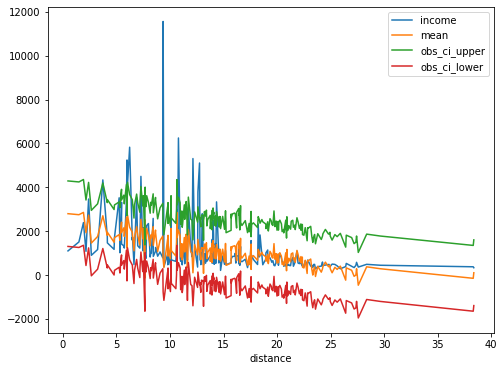

dif:  1067.5479853483866
out:  0.052845528455284556


In [221]:
# *********************  Предсказательная сила ****************
Y_te = nd_test['income']

DUM = pd.get_dummies(nd_test[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_te = pd.concat([DUMy, nd_test[['distance', 'density', 'household_size']]], axis=1)
X_te = sm.add_constant(X_te)

pred_ols = fitmod00.get_prediction(X_te)

# Генерация доверительных интервалов с доверительной вероятностью alpha
frm = pred_ols.summary_frame(alpha=0.05)
iv_l = frm["obs_ci_lower"] # Нижняя граница доверительных интервалов
iv_u = frm["obs_ci_upper"] # Верхняя граница доверительных интервалов
fv = frm['mean'] # Предсказанное значение целевой переменной

# Построение графиков
name = 'distance' # Имя переменной относительно которой строим прогноз
Z = X_te.loc[:, name]
dfn = pd.DataFrame([Z, Y_te, fv, iv_u, iv_l]).T
dfn = dfn.sort_values(by=name)
fig, ax = plt.subplots(figsize=(8, 6))
for z in dfn.columns[1:]:
    dfn.plot(x=dfn.columns[0], y=z, ax=ax)
ax.legend(loc="best")
plt.show()

# Подсчет среднеквадратической ошибки
dif = np.sqrt((dfn.iloc[:,1] - dfn.iloc[:,2]).pow(2).sum()/dfn.shape[0])
print('dif: ', dif)

# ****** Доля выходов за границы доверительых интервалов
mn = dfn.iloc[:,1].sort_index()
out = (mn > iv_u) + (mn < iv_l)
out1 = ((mn > iv_u) + (mn < iv_l)).sum()/dfn.shape[0]
print('out: ', out1)

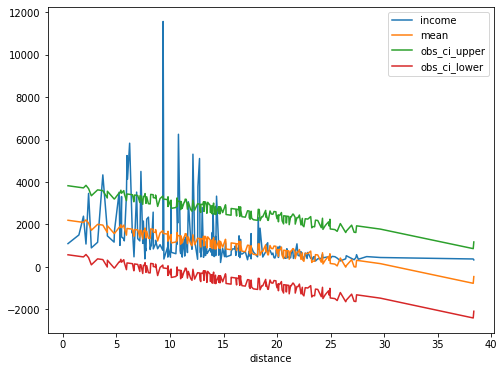

dif:  1079.1433677127338
out:  0.06504065040650407


In [222]:
# *********************  Предсказательная сила ****************
Y_te = nd_test['income']

DUM = pd.get_dummies(nd_test[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_te = pd.concat([DUMy, nd_test[['distance']]], axis=1)
X_te = sm.add_constant(X_te)

pred_ols = fitmod05.get_prediction(X_te)

# Генерация доверительных интервалов с доверительной вероятностью alpha
frm = pred_ols.summary_frame(alpha=0.05)
iv_l = frm["obs_ci_lower"] # Нижняя граница доверительных интервалов
iv_u = frm["obs_ci_upper"] # Верхняя граница доверительных интервалов
fv = frm['mean'] # Предсказанное значение целевой переменной

# Построение графиков
name = 'distance' # Имя переменной относительно которой строим прогноз
Z = X_te.loc[:, name]
dfn = pd.DataFrame([Z, Y_te, fv, iv_u, iv_l]).T
dfn = dfn.sort_values(by=name)
fig, ax = plt.subplots(figsize=(8, 6))
for z in dfn.columns[1:]:
    dfn.plot(x=dfn.columns[0], y=z, ax=ax)
ax.legend(loc="best")
plt.show()

# Подсчет среднеквадратической ошибки
dif = np.sqrt((dfn.iloc[:,1] - dfn.iloc[:,2]).pow(2).sum()/dfn.shape[0])
print('dif: ', dif)

# ****** Доля выходов за границы доверительых интервалов
mn = dfn.iloc[:,1].sort_index()
out = (mn > iv_u) + (mn < iv_l)
out1 = ((mn > iv_u) + (mn < iv_l)).sum()/dfn.shape[0]
print('out: ', out1)

In [223]:
mq

,R^2,adjR^2,AIC
base_01,0.387471,0.383714,15861.888263
base_01,0.586004,0.583467,16223.667121
base_01,0.585748,0.583635,16222.276050
base_01,0.383433,0.380284,15866.360512
base_01,0.360542,0.357279,16649.911343
base_01,0.271419,0.267698,16030.788724
base_01,0.269760,0.266779,16031.029523


# Hypothesis testing

In [201]:
# 2 hypothesis model 20
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_new = pd.DataFrame(nd_train[['distance']].apply(lambda x: (x - 20) ** 2)).rename({'distance':'distance_sq'}, axis=1)
X = pd.concat([DUMy, nd_train[['distance', 'density', 'household_size']], X_new['distance_sq']], axis=1)
X = sm.add_constant(X)
linreg20 = sm.OLS(Y,X)
fitmod20 = linreg20.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod20.summary())

q = pd.DataFrame([fitmod20.rsquared, fitmod20.rsquared_adj, fitmod20.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

from statsmodels.stats.diagnostic import het_white
e = fitmod20.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     89.58
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.00e-100
Time:                        23:32:12   Log-Likelihood:                -7921.2
No. Observations:                 985   AIC:                         1.586e+04
Df Residuals:                     977   BIC:                         1.590e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,184.526033
1,parks_qual_having_parks,1.008456
2,favelas_qual_moderate_favelas,1.104614
3,favelas_qual_lot_favelas,1.110995
4,distance,1.663069
5,density,1.038783
6,household_size,1.636860
7,distance_sq,1.457545


,0
LM,8.427062e+01
LM_P,4.720267e-07
F,2.975151e+00
F_P,2.159377e-07


In [202]:
# 2 hypothesis testing model 21
# no household_size no density
DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_new = pd.DataFrame(nd_train[['distance']].apply(lambda x: (x - 20) ** 2)).rename({'distance':'distance_sq'}, axis=1)
X = pd.concat([DUMy, nd_train[['distance']], X_new], axis=1)
X = sm.add_constant(X)
linreg21 = sm.OLS(Y,X)
fitmod21 = linreg21.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod21.summary())

q = pd.DataFrame([fitmod21.rsquared, fitmod21.rsquared_adj, fitmod21.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

e = fitmod21.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     80.26
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.20e-70
Time:                        23:32:12   Log-Likelihood:                -7996.2
No. Observations:                 985   AIC:                         1.600e+04
Df Residuals:                     979   BIC:                         1.603e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,13.462455
1,parks_qual_having_parks,1.008220
2,favelas_qual_moderate_favelas,1.073864
3,favelas_qual_lot_favelas,1.071712
4,distance,1.348237
5,distance_sq,1.361133


,0
LM,5.704466e+01
LM_P,8.064664e-07
F,3.971188e+00
F_P,5.141104e-07


In [203]:
# 3 hypothesis testing model 30
# no household_size no density + 
# a1 * lot_favelas * density + a2 * moderate_favelas * density + a3 * distance / density

DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_new = pd.DataFrame()
X_new['lot_fav_density'] = DUMy['favelas_qual_lot_favelas'] * nd_train['density']
X_new['mod_fav_density'] = DUMy['favelas_qual_moderate_favelas'] * nd_train['density']
X_new['dist_density'] = nd_train['distance'] / nd_train['density']
X = pd.concat([DUMy, nd_train[['distance']], X_new], axis=1)
X = sm.add_constant(X)
linreg30 = sm.OLS(Y,X)
fitmod30 = linreg30.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod30.summary())

q = pd.DataFrame([fitmod30.rsquared, fitmod30.rsquared_adj, fitmod30.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

e = fitmod30.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     52.25
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.18e-63
Time:                        23:32:12   Log-Likelihood:                -8008.7
No. Observations:                 985   AIC:                         1.603e+04
Df Residuals:                     977   BIC:                         1.607e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,7.370157
1,parks_qual_having_parks,1.009302
2,favelas_qual_moderate_favelas,1.974098
3,favelas_qual_lot_favelas,2.579979
4,distance,1.040059
5,lot_fav_density,2.506132
6,mod_fav_density,1.908948
7,dist_density,1.022770


,0
LM,54.435464
LM_P,0.000373
F,2.339890
F_P,0.000294


In [204]:
# 3 hypothesis testing model 31
# no household_size no density + 
# a1 * lot_favelas * density + a2 * moderate_favelas * density + a3 * distance / density

DUM = pd.get_dummies(nd_train[['parks_qual', 'favelas_qual']])
DUMy = DUM[['parks_qual_having_parks', 'favelas_qual_moderate_favelas', 'favelas_qual_lot_favelas']]
X_new = pd.DataFrame(nd_train[['distance']].apply(lambda x: (x - 20) ** 2)).rename({'distance':'distance_sq'}, axis=1)
X_new['lot_fav_density'] = DUMy['favelas_qual_lot_favelas'] * nd_train['density']
X_new['mod_fav_density'] = DUMy['favelas_qual_moderate_favelas'] * nd_train['density']
X_new['dist_density'] = nd_train['distance'] / nd_train['density']
X = pd.concat([DUMy, nd_train[['distance', 'household_size', 'density']], X_new], axis=1)
X = sm.add_constant(X)
linreg31 = sm.OLS(Y,X)
fitmod31 = linreg31.fit()
print('\n **** Оценка базовой модели - полный состав ****')
print(fitmod31.summary())

q = pd.DataFrame([fitmod31.rsquared, fitmod31.rsquared_adj, fitmod31.aic], 
                 index=['R^2', 'adjR^2', 'AIC'], columns=['base_01']).T
mq = pd.concat([mq, q])

vif = pd.DataFrame()
X_q = X
vif["vars"] = X_q.columns
vif["VIF"] = [variance_inflation_factor(X_q.values, i) 
              for i in range(X_q.shape[1])]
display(vif)

e = fitmod31.resid
WHT = pd.DataFrame(het_white(e, X), index=['LM', 'LM_P', 'F', 'F_P'])
WHT


 **** Оценка базовой модели - полный состав ****
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     63.22
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           9.22e-99
Time:                        23:32:12   Log-Likelihood:                -7919.0
No. Observations:                 985   AIC:                         1.586e+04
Df Residuals:                     974   BIC:                         1.591e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,vars,VIF
0,const,185.586453
1,parks_qual_having_parks,1.009518
2,favelas_qual_moderate_favelas,2.231089
3,favelas_qual_lot_favelas,2.715661
4,distance,1.875486
5,household_size,1.662292
6,density,1.570330
7,distance_sq,1.631730
8,lot_fav_density,2.900321
9,mod_fav_density,2.605406


,0
LM,1.160738e+02
LM_P,1.443309e-07
F,2.604869e+00
F_P,4.011928e-08
